# LIBOR futures and forecasting the Fed Funds rate

We examine the spread between two interest rates: LIBOR and Fed Funds. 
The former has a much greater depth in the futures market in terms of 
volume and maturity horizon, which implies richer information content. 
We will observe their relationship, and then construct a 
synthetic forward Fed Funds rate. This is useful in 
gauging market expectations regarding Fed policy.

The **30-day Federal Funds *futures* incorporates market expectations of the 
average *daily* Federal Funds Effective Rate (FFER) levels *during* a given contract month**. 
The FFER is published by the Federal Reserve Bank of New York each day, and is 
calculated as a transaction-volume weighted average of the previous day’s rates on 
trades arranged by major brokers for overnight unsecured loans between depository institutions. 
Trading of the futures contracts is considered very thin, 
especially in the distant months.

In contrast, the **futures on LIBOR (CME Eurodollar contract)** has a 
tenor of 3-months with tremendous trading volume extending out for years. 

Our synthetic forward Fed Funds *estimates* the expected average FFER *during* 
a given contract month. This is measure is more meaningful than the 
probability of Fed rate hike currently in vogue, since it is an estimate 
generated from a highly active futures market curve.

In conclusion, we shall sum up with one number to this simple 
question: **How much is the Fed Funds expected to change over the next 12 months?** 
and from that, likely Fed policy decisions.

2016-01-11 **Addendum: we distilled this notebook into one function *forefunds()* 
given in Appendix 3.** Surprisingly, our synthetic forward Fed Funds is redundant. 
Furthermore, that function is generalized to accept arguments further out than 12 months.

REFERENCE: 

- John W. Labuszewski, *Understanding Eurodollar Futures*, https://www.cmegroup.com/trading/interest-rates/files/understanding-eurodollar-futures.pdf

- Scoring the Fed's *dual mandate*, https://git.io/fed -- economic conditions which motivate FOMC policy decisions.

- Shortcut for this current notebook: https://git.io/fedfunds

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas
     
*CHANGE LOG*

    2016-01-11  Fix issue #2 by v4 and p6 updates.
                   Include 2015-12-16 Fed rate hike.
                   Rollover from Dec to June futures cycle.
                   Deprecate ratio_av estimation.
                   Add Appendix 2 for forwards as predictors.
                   Add Appendix 3 for forefunds() summary.
    2015-11-02  Include October Fed no-change announcement.
    2015-09-22  Include post-FOMC meeting of 2015-09-17.
    2015-09-16  First version.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.10
 ::  IPython 4.0.0
 ::  jupyter 1.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  Repository: fecon235 v4.15.1230 develop
 ::  Timestamp: 2016-01-12, 18:17:06 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


In [3]:
#  SET UP the particular (f4) futures contracts of interest:

s_fed    = 'f4fed16m'

s_libor  = 'f4libor16m'
s_libory = 'f4libor17m'

#  f4fed*   refers to the CME/CBOT Fed Funds futures.
#  f4libor* refers to the CME Eurodollar futures.
#  Both should reference the same year and month, 
#  except for s_libory which should be one year further out.

#  RE-RUN this entire study by merely changing the string symbols.

In [4]:
#  Retrieve data:
fed     = todf( 100 - get(s_fed)   )
libor   = todf( 100 - get(s_libor) )
libory  = todf( 100 - get(s_libory) )
#               ^convert futures quotes to conventional % format

In [5]:
#  Let "spread" denote their arithmetic difference:
spread = todf( libor - fed )

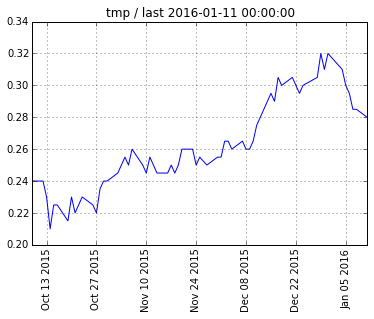

In [6]:
plot( tail(spread, 64) )

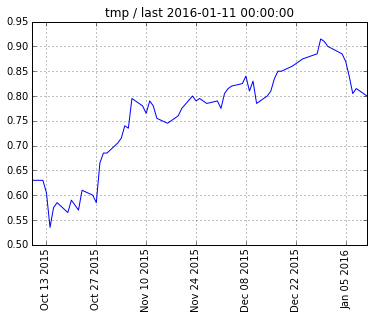

In [7]:
plot( tail(libor, 64) )
#         Approx. 64 trading days during one quarter.

The underlying *libor* is an instrument of 90-day duration, 
whereas *fed* is the average of erratic 30 one-day durations. 
Thus the spread expresses the additive relation between 
3-month and 1-month rates (including the credit risk of primary international banks).

In [8]:
##  2016-01-09  DEPRECATE ratio_av estimation,
##              in favor of additive spread structure:
##  1. Multiplicative structure is less robust,
##  2. and it will fail if rates go negative.
##  3. Want similar model for ECB and SNB.

#  Let "ratio" denote the ratio between spread and libor:
## ratio = todf( div(spread, libor) ) 
#  as a way to filter out the trends.
## ratio_av = ratio.mean()
#  So let's create SYNTHETIC Fed Funds:
## fedsyn = todf( (1 - ratio_av) * libor )
#  2015-09-16  ratio_av = 0.358
#  2015-11-02  ratio_av = 0.370

#### Event log

2015-11-02  No press conference for October Fed announcement 
so no major changes were expected, and indeed there was 
no change in policy regarding Fed funds. Fed statement removed 
its concern about economic developments *abroad* and 
hinted possible rate hike in December.

2016-01-09  **The Fed had its first rate hike, in almost a decade, on 2015-12-16.** 
It was widely anticipated, and largely discounted in the markets -- 
which is evident in the last chart. Although the hike was +25 bp, 
the response in the traded rate was only +7 bp. 

## On rate hike probabilities and forecasting

The media is fond of releasing the probability of a rate hike based on Fed Funds futures, however, the assumptions behind the calculation are often dubious 
given that the Fed currently operates within a *range* 
[2015-09-16: zero to 25 bp range since 16 December 2008. Effective 2015-12-17: 25 to 50 bp] 
rather than a single target rate.

We now estimated the expected average FFER (Fed Funds Effective Rate) *during* 
the distant contract month by subtracting 
the spread from the LIBOR futures one year out from the initial contract month.

In [9]:
#  Let's estimate Fed Funds 1-year out:
fedy = todf( libory - spread )

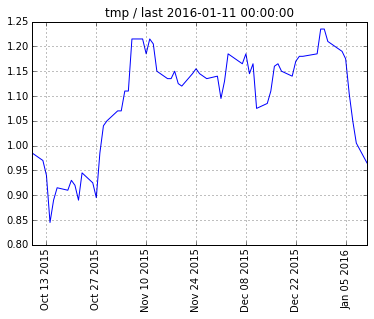

In [10]:
#  SYNTHETIC Fed Funds, distant forward rate:
plot( tail(fedy, 64) )

## Interim CONCLUSION: point forecast for Fed Funds

Let's address this simple question: **How much is the Fed Funds 
expected to change over the next 12 months?**

We can compute the synthetic difference between Fed Funds 
futures one year apart, and *apply that to the current 
estimated Fed Funds effective rate* (see Appendix 1).

In [11]:
#  Taking this difference minimizes the effects of the yield curve:
tailvalue( fedy ) - tailvalue( fed )

#  2015-09-16  Answer: +43 bp from current 14 bp effective rate, 
#                             so FFER est. at 0.57% in one year.
#
#  2015-09-22  Answer: +38 bp from current 14 bp effective rate,
#                             so FFER est. at 0.52% in one year.
#
#  2015-11-02  Answer: +38 bp from current 12 bp effective rate,
#                             so FFER est. at 0.50% in one year.
#
#  2016-01-11  Answer: +45 bp from current 28 bp effective rate,
#                             so FFER est. at 0.73% in one year.

0.4450000000000074

2015-09-22  Currently our **point forecast for FFER one-year out is 0.52%**. Given our standard error computed above, this implies in terms of expected Fed action: one rate hike of 25 bp (keeping actual in the upper range) or two rate hikes of 25 bp (keeping actual in the lower [0.50, 0.75] range).

2015-11-02  **Point forecast for FFER one-year out is 0.50%**, thus no change in conclusion is warranted.

2016-01-11  Point forecast for FFER one-year out is 0.73%. **Given the 2015-12-16 rate hike, this implies in terms of expected Fed action: one further rate hike of 25 bp 
(keeping actual in the upper range), or two rate hikes of 25 bp 
(keeping actual in the lower [0.75, 1.00] range).**
Interestingly, the Fed's own blue dot plot seems to suggest 1.0% is reasonable in one year.

## Appendix 1: FFER, Fed Funds Effective Rate

Here we cover the actual Fed Funds rate (not the futures).

In [12]:
#  The data source is the Federal Reserve Bank of St. Louis:
ffer = getfred( 'DFF')
#               ^Daily frequency

In [13]:
#  To see the raw FFER over the last year:
#  plot( tail( ffer, 256 ))

In [14]:
#  FFER is notoriously erratic, 

#  we shall apply a double Holt-Winters filter: DEPRECATED
## ffer_holt = holtlevel( holtlevel( ffer ))

#  we shall apply the 30-period EWMA:
ffer_ema = ema(ffer, 0.0645)
#  This is cheaper and faster computationally.

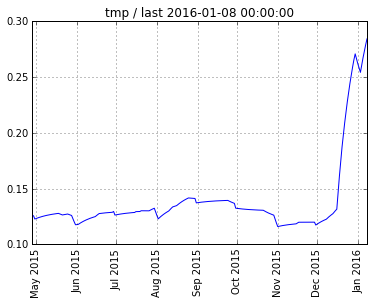

In [15]:
#  Estimate current FFER by "Exponentially Weighted Moving Average":
plot( tail(ffer_ema, 256) )

2015-09-16  We can safely say that FFER has been trading around mid-range [0, 0.25] for the last year.

2015-11-02  FFER estimated at 12 bp currently (this is mid-target range).

2016-01-11  Smoothed FFER estimated at 28 bp.

## Appendix 2: Forward rates as predictors

We have implicitly assumed in this notebook that rates which are 
traded forward in time are market predictions. But are they 
accurate predictors? This is will require a backtesting framework. 
It is fairly common to see this type of assumption tested 
in commodity and foreign exchange markets.

For now, we will just leave some visual evidence as a teaser. 
LIBOR forwards can be persistently wrong-headed, 
for example, see the 2009-2012 period below. 
The long end of the forward curve is dominated by 
the yield curve, but generally the short end does 
reflect news narratives of market expectations.

In [16]:
Image(url='http://bit.ly/libor-fwd_jpg', embed=False)

## Appendix 3: Forecasting Fed Funds, distilled

After data exploration and doing the "algebra" behind the 
individual computations, it is interesting to see that *what 
we suspected to be important can in fact be dropped as 
redundant: the synthetic Fed Funds.*

From the smoothed Fed Funds effective rate, 
we can just simply add the differential between Libor forwards 
to arrive at our forecast! We distill the technique as *forefunds()* 
which shall be in the fecon235 module.

We can generalize the notebook logic to make forecasts into 
the very long-term since Libor futures is very active 
extending out to distant contract years (unlike the Fed Funds futures).

In [17]:
forefunds??

Signature: forefunds(nearby='16m', distant='17m')
Source:
def forefunds( nearby='16m', distant='17m' ):
    '''Forecast distant Fed Funds rate using Eurodollar futures.'''
    #  Long derivation is given in qdl-libor-fed-funds.ipynb
    ffer = getfred('DFF')
    #      ^Retrieve Fed Funds effective rate, daily since 1954.
    ffer_ema = ema( ffer['1981':], 0.0645 )
    #                    ^Eurodollar futures debut.
    #          ^Exponentially Weighted Moving Average, 30-period.
    libor_nearby  = get( 'f4libor' + nearby  ) 
    libor_distant = get( 'f4libor' + distant )
    libor_spread = todf( libor_nearby - libor_distant )
    #     spread in forward style quote since futures uses 100-rate.
    return todf( ffer_ema + libor_spread )
File:      ~/Dropbox/ipy/fecon235/fecon235.py
Type:      function

In [18]:
ff = forefunds( nearby='16h', distant='17h' )
#    The arguments are simply coded contract months.
#    For example, distant='18h' would give 2 year forecasts.

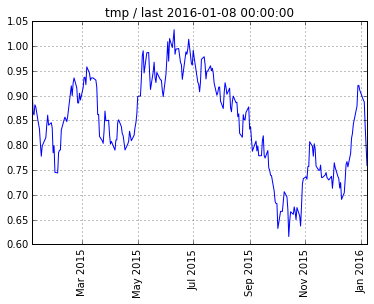

In [19]:
#  Most recent 12-months ahead FORECASTS for FED FUNDS:
plot(tail(ff, 256))

## FINAL CONCLUSIONS

2016-01-11  We used forefunds() to replicate our notebook exploration, however, 
the March cycle was used instead of using the June futures cycle 
to double-check our implicit assumption of parallel yield curve shift.

Point forecast for FFER one-year out is 0.76% (3 bp higher than June cycle). 
**Given the 2015-12-16 rate hike, this implies in terms of expected Fed action: 
one further rate hike of 25 bp (keeping actual in the upper range), or 
two rate hikes of 25 bp (keeping actual in the lower [0.75, 1.00] range).**

Interestingly, the Fed's own blue dot plot seems to suggest 1.0% 
is reasonable in one year. Yet the forecast plot shows that to be 
the most optimistic upper bound expected by the market throughout 2015.